In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
target_gu = '강서구'
target_dong = '방화'
#target_purpose = '준주거'
target_building_age = 3
target_period = 36 # in months

In [3]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [4]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210729'

In [5]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [6]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [7]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [8]:
apart_df = data_prep('아파트', '매매')
apart_df['부동산유형'] = '아파트'
print(apart_df.shape)
apart_df.head()

16it [00:02,  6.87it/s]


(1204461, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,59500,7,1988,18,2006-03-10,765.273312,33,아파트
1,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,6,1988,18,2006-03-29,771.704180,33,아파트
2,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,67000,9,1988,18,2006-04-29,861.736334,33,아파트
3,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,60000,4,1988,18,2006-06-01,771.704180,33,아파트
4,서울특별시 강남구 개포동 655-2,언주로 103,개포2차현대아파트(220),77.75,72250,5,1988,18,2006-10-20,929.260450,33,아파트


In [9]:
yunrip_df = data_prep('연립다세대', '매매')
yunrip_df['부동산유형'] = '연립다세대'
print(yunrip_df.shape)
yunrip_df.head()

16it [00:01,  9.27it/s]


(645406, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [10]:
officetel_df = data_prep('오피스텔', '매매')
officetel_df['부동산유형'] = '오피스텔'
print(officetel_df.shape)
officetel_df.head()

16it [00:00, 30.70it/s]


(183523, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,6400,8,1997.0,9.0,2006-01-10,197.287300,24.0,오피스텔
1,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7100,7,1997.0,9.0,2006-01-10,218.865598,24.0,오피스텔
2,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7300,11,1997.0,9.0,2006-01-11,225.030826,24.0,오피스텔
3,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,31.91,7500,10,1997.0,9.0,2006-01-18,235.036039,24.0,오피스텔
4,서울특별시 강남구 개포동 13-3,개포로 623,대청타워,32.44,7400,15,1997.0,9.0,2006-01-19,228.113440,24.0,오피스텔


In [11]:
yunrip_df = yunrip_df.drop(columns=['대지권면적(㎡)'])
house_df = pd.concat([apart_df, yunrip_df, officetel_df]).sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
print(house_df.shape)
house_df.head()

(2033390, 12)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57500,2,2017.0,1.0,2018-01-20,990.525409,4.0,연립다세대
1,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,57000,1,2017.0,1.0,2018-06-01,981.912145,4.0,연립다세대
2,서울특별시 강남구 개포동 1164-0,논현로2길 6,골드캐슬,58.05,63000,2,2017.0,2.0,2019-01-19,1085.271318,4.0,연립다세대
3,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),71.72,64500,7,2000.0,17.0,2017-09-23,899.330731,21.0,아파트
4,서울특별시 강남구 개포동 1164-12,논현로2길 34,새롬(1164-12),73.50,29800,4,2000.0,6.0,2006-10-18,405.442177,21.0,아파트


In [12]:
'''land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()'''

"land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')\nprint(land_specs_df.shape)\nland_specs_df.head()"

In [13]:
'''last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()'''

"last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)\nprint(last_df.shape)\nlast_df.head()"

In [14]:
'''house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)'''

"house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)\nprint(house_merge_df.shape)"

In [15]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
#house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
#house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [16]:
target_1_12_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=12)))
    &(house_df['건물연식'] <= 1)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_1_12_df.shape)
target_1_12_df.head()

(124, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
321682,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.25,27500,4,2020.0,1.0,2021-05-25,940.170940,1.0,연립다세대,강서구,방화동
321683,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.33,28500,4,2020.0,1.0,2021-04-08,971.701330,1.0,연립다세대,강서구,방화동
321684,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.50,27500,5,2020.0,1.0,2021-05-20,932.203390,1.0,연립다세대,강서구,방화동
321685,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.58,26900,6,2020.0,1.0,2021-07-15,909.398242,1.0,연립다세대,강서구,방화동
321686,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.88,29500,5,2020.0,1.0,2021-01-25,987.282463,1.0,연립다세대,강서구,방화동


In [17]:
target_2_24_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=24)))
    &(house_df['건물연식'] <= 2)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_2_24_df.shape)
target_2_24_df.head()

(200, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
321107,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,26000,3,2019.0,0.0,2019-10-25,866.666667,2.0,연립다세대,강서구,방화동
321108,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,22000,2,2019.0,1.0,2020-10-21,733.333333,2.0,연립다세대,강서구,방화동
321109,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,25500,3,2019.0,1.0,2020-11-17,850.000000,2.0,연립다세대,강서구,방화동
321110,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.15,19700,4,2019.0,0.0,2019-12-17,653.399668,2.0,연립다세대,강서구,방화동
321111,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,41.38,32000,4,2019.0,1.0,2020-02-20,773.320445,2.0,연립다세대,강서구,방화동


In [18]:
target_3_36_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=36)))
    &(house_df['건물연식'] <= 3)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_3_36_df.shape)
target_3_36_df.head()

(290, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
321107,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,26000,3,2019.0,0.0,2019-10-25,866.666667,2.0,연립다세대,강서구,방화동
321108,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,22000,2,2019.0,1.0,2020-10-21,733.333333,2.0,연립다세대,강서구,방화동
321109,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,25500,3,2019.0,1.0,2020-11-17,850.000000,2.0,연립다세대,강서구,방화동
321110,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.15,19700,4,2019.0,0.0,2019-12-17,653.399668,2.0,연립다세대,강서구,방화동
321111,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,41.38,32000,4,2019.0,1.0,2020-02-20,773.320445,2.0,연립다세대,강서구,방화동


In [19]:
target_5_60_df = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    &(house_df['계약날짜'] >= (date_today - pd.DateOffset(months=60)))
    &(house_df['건물연식'] <= 5)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_5_60_df.shape)
target_5_60_df.head()

(543, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
321107,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,26000,3,2019.0,0.0,2019-10-25,866.666667,2.0,연립다세대,강서구,방화동
321108,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,22000,2,2019.0,1.0,2020-10-21,733.333333,2.0,연립다세대,강서구,방화동
321109,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,25500,3,2019.0,1.0,2020-11-17,850.000000,2.0,연립다세대,강서구,방화동
321110,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.15,19700,4,2019.0,0.0,2019-12-17,653.399668,2.0,연립다세대,강서구,방화동
321111,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,41.38,32000,4,2019.0,1.0,2020-02-20,773.320445,2.0,연립다세대,강서구,방화동


In [20]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [21]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [22]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [23]:
target_1_12_df = get_index_applied_prices(target_1_12_df)
print(target_1_12_df.shape)
target_1_12_df.head()

(124, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
321682,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.25,27500,4,2020.0,1.0,2021-05-25,940.170940,1.0,연립다세대,강서구,방화동,940.170940,2021-05-25
321683,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.33,28500,4,2020.0,1.0,2021-04-08,971.701330,1.0,연립다세대,강서구,방화동,987.511892,2021-05-01
321684,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.50,27500,5,2020.0,1.0,2021-05-20,932.203390,1.0,연립다세대,강서구,방화동,932.203390,2021-05-20
321685,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.58,26900,6,2020.0,1.0,2021-07-15,909.398242,1.0,연립다세대,강서구,방화동,909.398242,2021-07-15
321686,서울특별시 강서구 방화동 247-158,방화대로33길 32-22,동원아트빌,29.88,29500,5,2020.0,1.0,2021-01-25,987.282463,1.0,연립다세대,강서구,방화동,1029.017764,2021-05-01


In [24]:
target_2_24_df = get_index_applied_prices(target_2_24_df)
print(target_2_24_df.shape)
target_2_24_df.head()

(200, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
321107,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,26000,3,2019.0,0.0,2019-10-25,866.666667,2.0,연립다세대,강서구,방화동,1019.270629,2021-05-01
321108,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,22000,2,2019.0,1.0,2020-10-21,733.333333,2.0,연립다세대,강서구,방화동,796.272834,2021-05-01
321109,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,25500,3,2019.0,1.0,2020-11-17,850.000000,2.0,연립다세대,강서구,방화동,903.272355,2021-05-01
321110,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.15,19700,4,2019.0,0.0,2019-12-17,653.399668,2.0,연립다세대,강서구,방화동,762.267045,2021-05-01
321111,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,41.38,32000,4,2019.0,1.0,2020-02-20,773.320445,2.0,연립다세대,강서구,방화동,890.499013,2021-05-01


In [25]:
target_3_36_df = get_index_applied_prices(target_3_36_df)
print(target_3_36_df.shape)
target_3_36_df.head()

(290, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
321107,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,26000,3,2019.0,0.0,2019-10-25,866.666667,2.0,연립다세대,강서구,방화동,1019.270629,2021-05-01
321108,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,22000,2,2019.0,1.0,2020-10-21,733.333333,2.0,연립다세대,강서구,방화동,796.272834,2021-05-01
321109,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,25500,3,2019.0,1.0,2020-11-17,850.000000,2.0,연립다세대,강서구,방화동,903.272355,2021-05-01
321110,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.15,19700,4,2019.0,0.0,2019-12-17,653.399668,2.0,연립다세대,강서구,방화동,762.267045,2021-05-01
321111,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,41.38,32000,4,2019.0,1.0,2020-02-20,773.320445,2.0,연립다세대,강서구,방화동,890.499013,2021-05-01


In [26]:
target_5_60_df = get_index_applied_prices(target_5_60_df)
print(target_5_60_df.shape)
target_5_60_df.head()

(543, 16)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜
321107,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,26000,3,2019.0,0.0,2019-10-25,866.666667,2.0,연립다세대,강서구,방화동,1019.270629,2021-05-01
321108,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,22000,2,2019.0,1.0,2020-10-21,733.333333,2.0,연립다세대,강서구,방화동,796.272834,2021-05-01
321109,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.00,25500,3,2019.0,1.0,2020-11-17,850.000000,2.0,연립다세대,강서구,방화동,903.272355,2021-05-01
321110,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,30.15,19700,4,2019.0,0.0,2019-12-17,653.399668,2.0,연립다세대,강서구,방화동,762.267045,2021-05-01
321111,서울특별시 강서구 방화동 168-70,양천로28길 12-13,마곡스카이 B단지,41.38,32000,4,2019.0,1.0,2020-02-20,773.320445,2.0,연립다세대,강서구,방화동,890.499013,2021-05-01


In [27]:
target_1_12_df = target_1_12_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_1_12_df1 = target_1_12_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_1_12_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식1년_최근12개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [28]:
target_2_24_df = target_2_24_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_2_24_df1 = target_2_24_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_2_24_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식2년_최근24개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [29]:
target_3_36_df = target_3_36_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_3_36_df1 = target_3_36_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_3_36_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식3년_최근36개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [30]:
target_5_60_df = target_5_60_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_5_60_df1 = target_5_60_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_5_60_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/실거래가_건물연식5년_최근60개월.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [31]:
target_df = target_3_36_df.copy()

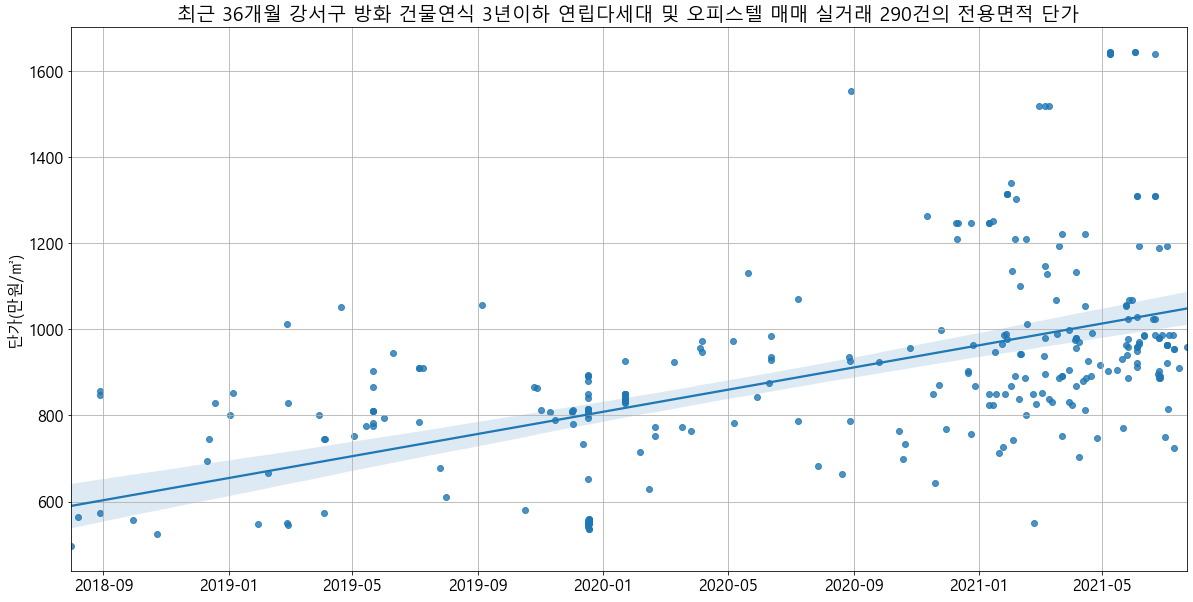

In [32]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/산포도.png'.format(target_gu, target_dong, date_today_record))

In [33]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

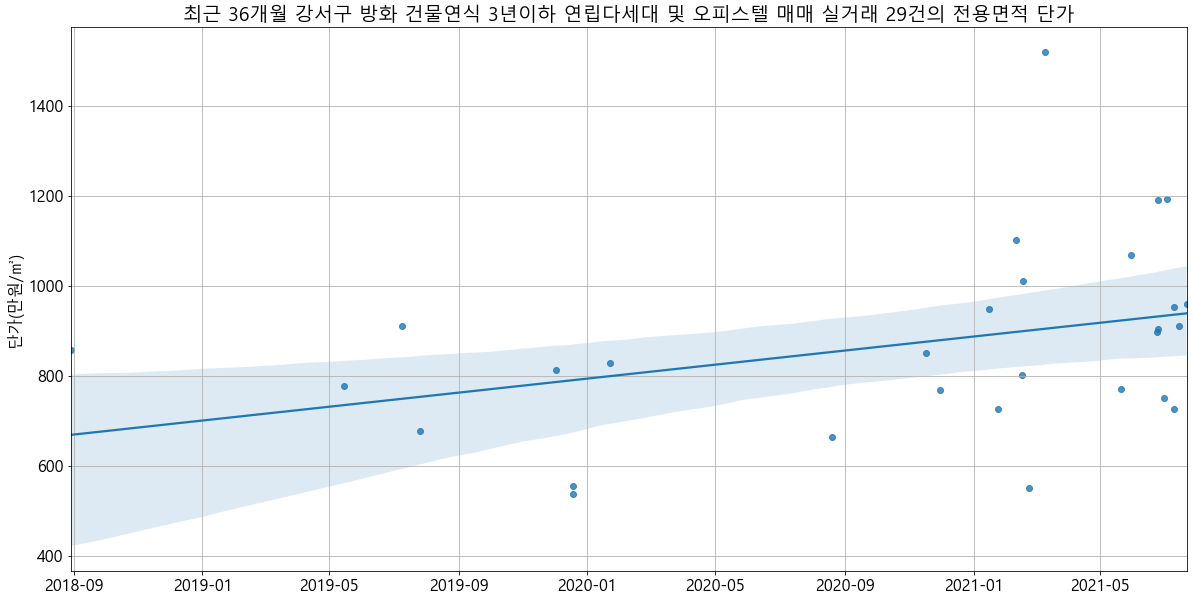

In [34]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_산포도.png'.format(target_gu, target_dong, date_today_record))

In [35]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [36]:
target_df2 = house_df[
    (house_df['지번주소'].str.contains(target_gu + ' ' + target_dong))
    #&(house_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(1861, 14)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동
320892,서울특별시 강서구 방화동 129-2,양천로27길 115-9,소담밸리,41.05,25500,6,2014.0,3.0,2017-03-07,621.193666,7.0,연립다세대,강서구,방화동
320893,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),23.61,13000,4,2010.0,0.0,2010-08-03,550.614147,11.0,연립다세대,강서구,방화동
320894,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),26.19,9500,5,2010.0,0.0,2010-09-25,362.733868,11.0,연립다세대,강서구,방화동
320896,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),29.96,13500,3,2010.0,0.0,2010-08-29,450.600801,11.0,연립다세대,강서구,방화동
320898,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),30.01,17000,4,2010.0,0.0,2010-07-22,566.477841,11.0,연립다세대,강서구,방화동


In [37]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'강서구 방화 계약날짜기준 건물연식 3년이하 연립다세대 및 오피스텔 매매 실거래 1861건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

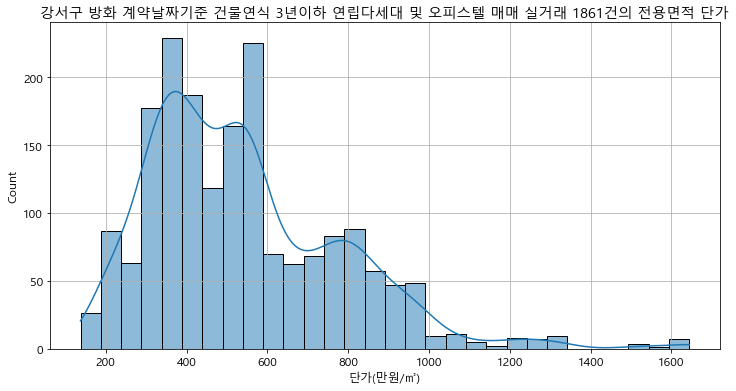

In [38]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [39]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [40]:
target_df3_30 = target_df3[
    (target_df3['전용면적(㎡)'] >= 28)
    &(target_df3['전용면적(㎡)'] <= 32)
]

In [41]:
target_df3_30.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_실거래가_30.xlsx'.format(target_gu, target_dong, date_today_record), index=False)

In [42]:
concat_df = pd.concat([target_df2])

In [43]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [44]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [45]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(621, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 강서구 방화동 129-2,양천로27길 115-9,소담밸리,41.05,25500,6,2014.0,3.0,2017-03-07,621.193666,7.0,연립다세대,강서구,방화동,827.803790,2021-05-01,621.193666,827.803790
1,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),23.61,13000,4,2010.0,0.0,2010-08-03,550.614147,11.0,연립다세대,강서구,방화동,774.647350,2021-05-01,471.574645,661.939599
2,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),26.19,9500,5,2010.0,0.0,2010-09-25,362.733868,11.0,연립다세대,강서구,방화동,510.741221,2021-05-01,471.574645,661.939599
3,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),29.96,13500,3,2010.0,0.0,2010-08-29,450.600801,11.0,연립다세대,강서구,방화동,633.940698,2021-05-01,471.574645,661.939599
4,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),30.01,17000,4,2010.0,0.0,2010-07-22,566.477841,11.0,연립다세대,강서구,방화동,792.427540,2021-05-01,471.574645,661.939599


In [46]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(195, 18)


,지번주소,도로명,건물(단지)명,전용면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 강서구 방화동 129-2,양천로27길 115-9,소담밸리,41.0500,25500,6,2014.0,3.0,2017-03-07,621.193666,7.0,연립다세대,강서구,방화동,827.803790,2021-05-01,621.193666,827.803790
5,서울특별시 강서구 방화동 132-10,방화대로50길 37,예담쉐르빌2차(132-10),44.4500,19000,3,2010.0,0.0,2010-07-08,427.446569,11.0,연립다세대,강서구,방화동,597.941188,2021-05-01,471.574645,661.939599
7,서울특별시 강서구 방화동 132-90,방화대로52가길 27,공원빌,71.6800,30000,4,2010.0,1.0,2011-04-29,418.526786,11.0,연립다세대,강서구,방화동,582.860377,2021-05-01,410.728594,572.000243
8,서울특별시 강서구 방화동 134-1,방화대로52길 32,다대화이트빌B동,55.9200,10500,1,2003.0,3.0,2006-05-25,187.768240,18.0,연립다세대,강서구,방화동,451.980815,2021-05-01,187.768240,451.980815
12,서울특별시 강서구 방화동 134-12,방화대로50길 38,예담쉐르빌3차,45.6000,16300,3,2010.0,0.0,2010-04-15,357.456140,11.0,연립다세대,강서구,방화동,484.987184,2021-05-01,396.458727,543.193032
15,서울특별시 강서구 방화동 134-13,방화대로50길 42,예담쉐르빌4차,38.6200,17500,3,2010.0,0.0,2010-11-22,453.133092,11.0,연립다세대,강서구,방화동,637.649671,2021-05-01,430.903441,616.220969
16,서울특별시 강서구 방화동 134-20,방화대로52길 34,다대화이트빌A동,38.7000,9000,2,2003.0,3.0,2006-12-15,232.558140,18.0,연립다세대,강서구,방화동,455.581930,2021-05-01,232.558140,455.581930
30,서울특별시 강서구 방화동 136-10,방화대로50길 26,파크빌(136-10),59.3000,21600,3,2014.0,0.0,2014-10-29,364.249578,7.0,연립다세대,강서구,방화동,543.534836,2021-05-01,376.886814,562.392176
31,서울특별시 강서구 방화동 168-114,양천로 132,한림리첸빌102동,84.4200,18000,4,2005.0,1.0,2006-04-05,213.219616,16.0,아파트,강서구,방화동,518.872826,2021-05-01,213.219616,518.872826
32,서울특별시 강서구 방화동 168-38,양천로 128,한림리첸빌101동,84.4200,26500,7,2005.0,2.0,2007-01-04,313.906657,16.0,아파트,강서구,방화동,598.867376,2021-05-01,313.906657,598.867376


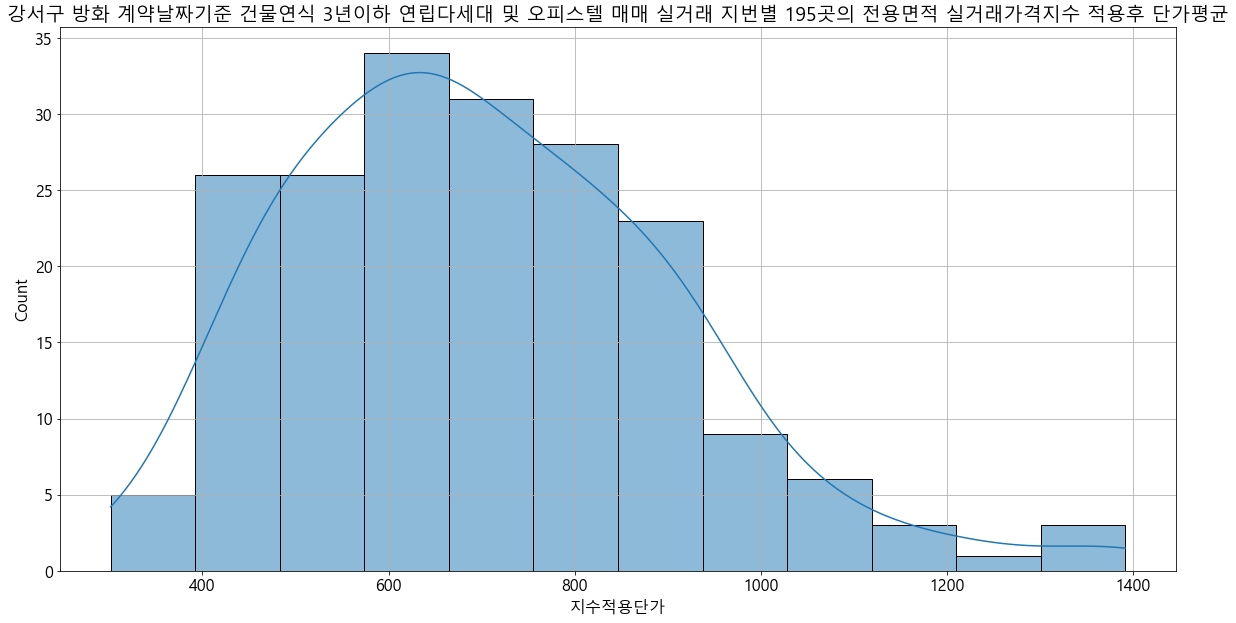

In [47]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 연립다세대 및 오피스텔 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지번별_분포도.png'.format(target_gu, target_dong, date_today_record))

In [48]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [49]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,부동산유형
0,서울특별시 강서구 방화동 129-2,소담밸리,2014.0,41.05,6,2017-03-07,621.193666,2021-05-01,827.803790,연립다세대
1,서울특별시 강서구 방화동 132-10,예담쉐르빌2차(132-10),2010.0,44.45,3,2010-07-08,427.446569,2021-05-01,597.941188,연립다세대
2,서울특별시 강서구 방화동 132-90,공원빌,2010.0,71.68,4,2011-04-29,418.526786,2021-05-01,582.860377,연립다세대
3,서울특별시 강서구 방화동 134-1,다대화이트빌B동,2003.0,55.92,1,2006-05-25,187.768240,2021-05-01,451.980815,연립다세대
4,서울특별시 강서구 방화동 134-12,예담쉐르빌3차,2010.0,45.60,3,2010-04-15,357.456140,2021-05-01,484.987184,연립다세대


In [50]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_연립다세대_오피스텔_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, date_today_record), index=False)